# Import Libs

In [9]:
# Import general functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import lib for saving model and encoder
import os
import pickle

# Import preprocessing functions
from sklearn.tree               import plot_tree
from sklearn.preprocessing      import LabelEncoder
from sklearn.model_selection    import train_test_split

# Import confusion_matrix and roc_auc_curve
from sklearn import metrics

# Import metrics functions
from sklearn.metrics import f1_score,                           \
                            r2_score,                           \
                            recall_score,                       \
                            accuracy_score,                     \
                            precision_score,                    \
                            mean_squared_error,                 \
                            mean_absolute_error,                \
                            balanced_accuracy_score,            \
                            precision_recall_fscore_support
                            

In [10]:
build_path = "build_files/"

# Preprocessing

In [11]:
# Import dataset
data = pd.read_excel('src/dataset_norm.xlsx')

# Define minimal mark
min_mark = 4

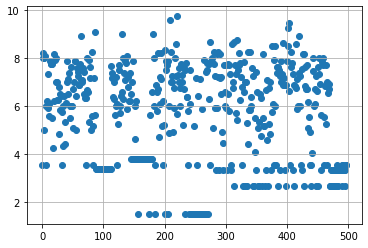

In [12]:
# Output distribution of scores
plt.scatter(
    range(len(data['Средний балл'])), 
    data['Средний балл']
    )
plt.grid()

NOTE: lines in graph illustrate custom increase the number of not pass students.
That trick were done for better model training. It helps to increase accuracy metricks of models

Lets find out how many students did not pass the exams

In [13]:
def counter_print():
    passed = 0
    not_passed = 0
    res = 0
    for mark in data['Средний балл']:
        if mark >= min_mark:
            passed += 1
        elif mark < min_mark:
            not_passed += 1
        res += 1
    print(f"TOTAL: {res}\nPassed: {passed}\nNot pas: {not_passed}")


counter_print()

TOTAL: 498
Passed: 341
Not pas: 157


In [14]:
# Replase mark of student by belonging to the class of successfully passed
data['Сдал'] = pd.cut(x=data['Средний балл'], bins=[0, min_mark, 10], labels=[0, 1])
data.drop(['Средний балл'], axis = 1, inplace= True)

# Drop indicators which are not connected with extracurricular activities
data.drop([
            'Дата прохождения теста',
            '15.Образование Ваших родителей?', 
            '3.С какими оценками Вы закончили школу?',
            '4.Ходили ли Вы на подготовительные курсы перед поступлением в вуз?',
            '7.Какая у Вас семья?',
            '10.Получали ли Вы стипендию? (в течение последнего года)',
            '11.Оцените, как Вам нравится учиться?',
            '13.На какие средства Вы живете?',
            '5.Брали ли Вы академический отпуск?',
            '17.Укажите Ваше семейное положение.',
            '12.Каковы условия Вашего проживания?'
            ],
            axis = 1, inplace = True)

# That part index all names for privacy reasons
name_hash = []
for idx, name in enumerate(data['Учащийся']):
    name_hash.append((idx, name))
    data.loc[idx,'Учащийся'] = idx

Dataset with concern questions

In [15]:
# Create a copy of dataset to use it in future work
debug_data = data

data.head()

,Учащийся,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,Сдал
0,0,Нет,"да, хожу на фитнес или в тренажерный зал",От 1 до 3 часов в день,Среднее количество пропусков,1-2 раза в семестр,нет,Нет,0
1,1,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,"Нет, но собираюсь в этом году",1
2,2,Да,"нет, не занимаюсь",Готовлюсь только перед занятиями,Регулярно пропускаете,Всегда,нет,Нет,1
3,3,Нет,"нет, не занимаюсь",Более 3 часов в день,Не пропускаете,Нет,нет,Нет,1
4,4,Нет,"да, занимаюсь шахматами/шашками;нет, не занимаюсь",Более 3 часов в день,Среднее количество пропусков,1-2 раза в год,нет,Да,1


Split our data in 3 parts for train, test and validation

In [16]:
def create(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [17]:
def train_test_val_split(test_ratio, validation_ratio):
# Replace all text output to index
    label_encoder = LabelEncoder()
    label_data = data.copy()
    s = (label_data.dtypes == 'object')
    object_cols = list(s[s].index)
    create(build_path)
    for col in object_cols:
        label_encoder.fit(label_data[col])
        label_data[col] = label_encoder.transform(label_data[col])
        # Save lable encouder hash to separate files to use them in future if need
        file_name = f'{build_path}/{col.replace("/", "-")}_class_linear_encoder.npy'
        f = open(file_name, 'w+')
        np.save(file_name, label_encoder.classes_)
        f.close()

# Split dataset
    # NOTE: To fix split selections use random_state= parameter
    size = label_data.shape[0]
    validation_ratio = (validation_ratio * size) / (size * (1 - test_ratio))

    X_train, X_test, y_train, y_test = train_test_split(label_data.drop('Сдал', axis = 1), 
                                                        label_data['Сдал'], 
                                                        test_size=test_ratio)

    X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                      y_train, 
                                                      test_size=validation_ratio)

    # Output X_train.iloc[:,1:] delete student hash from training and testing selections
    return X_train.iloc[:,1:], X_test.iloc[:,1:], X_val, y_train, y_test, y_val

In [18]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(test_ratio=0.25, validation_ratio=0.05)

In [19]:
X_train

,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?
269,1,14,0,0,3,0,1
247,1,14,8,1,1,7,1
140,1,8,9,0,3,3,1
209,1,20,5,0,3,7,0
54,1,12,3,0,3,3,2
...,...,...,...,...,...,...,...
480,1,14,9,2,0,1,0
146,1,14,1,0,3,3,1
367,1,12,1,2,1,7,1
151,1,20,9,0,3,7,0


# Model variants
In that part I will choose the classification model which will predict if student pass exams successfully or not

## Metrics Functions

In [20]:
def classification_quality(y_test, y_pred):
    print("Accuracy:",          accuracy_score(y_test, y_pred))
    print("Recall:",            recall_score(y_test, y_pred, average='macro'))
    print("Precision:",         precision_score(y_test, y_pred, average='macro'))
    print("F1:",                f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
    print("Weighted Recall:",   (precision_recall_fscore_support(y_test, y_pred, average='macro')))

In [21]:
# For historical reason
def regression_quality(y_test, y_pred):
    print("MSE:",               mean_squared_error(y_test, y_pred))
    print("RMSE:",              mean_squared_error(y_test, y_pred)**(1/2))
    print("MAE:",               mean_absolute_error(y_test, y_pred))
    print("R2:",                r2_score(y_test, y_pred))

In [22]:
metrics_list = ['Accuracy', 'Balanced Accuracy', 'Recall', 'Precision', 'F1', 'MSE', 'RMSE', 'MAE', 'R2']
model_array  = []
output_array = []

def compilance_print(model, y_test, y_pred, model_flag):
    temp_array = []
    if model_flag == 'cls': # Classifier
        temp_array.append(accuracy_score(y_test, y_pred))
        temp_array.append(balanced_accuracy_score(y_test, y_pred))
        temp_array.append(recall_score(y_test, y_pred, average='macro'))
        temp_array.append(precision_score(y_test, y_pred, average='macro'))
        temp_array.append(f1_score(y_test, y_pred, average='macro', labels=np.unique(y_pred)))
        for _ in range(4): temp_array.append(None) # Set regression metrics as None
    
    # For historical reason
    elif model_flag == 'reg': # Regression
        for _ in range(5): temp_array.append(None) # Set classifier metrics as None
        temp_array.append(mean_squared_error(y_test, y_pred))
        temp_array.append(mean_squared_error(y_test, y_pred)**(1/2))
        temp_array.append(mean_absolute_error(y_test, y_pred))
        temp_array.append(r2_score(y_test, y_pred))
    else: 
        print('Error')
        for _ in metrics_list: temp_array.append(None)

    flag = 1
    model_indx = -1
    for indx, _model in enumerate(model_array):
        if _model == model:
            model_indx = indx
            flag = 0
    if flag:
        output_array.append([0]* len(metrics_list))
        model_indx = len(model_array)
        model_array.append(model)
    for indx, el in enumerate(temp_array):
        output_array[model_indx][indx] = el

In [23]:
def graph_show(model, X, y):
    metrics.plot_confusion_matrix(model, X, y)
    metrics.plot_roc_curve(model, X, y)  
    plt.show()

## Classifier

### Perception Classifier Model

In [24]:
from sklearn.linear_model import Perceptron
Perc = Perceptron()
Perc.fit(X_train, y_train)

y_pred = Perc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('Perceptron', y_test, y_pred, 'cls')

Accuracy: 0.672
Recall: 0.7819148936170213
Precision: 0.7152777777777778
F1: 0.6615150914734826
Weighted Recall: (0.7152777777777778, 0.7819148936170213, 0.6615150914734826, None)


### Random Forest Classifier Model

In [25]:
from sklearn.ensemble import RandomForestClassifier
RanF = RandomForestClassifier()
RanF.fit(X_train, y_train)

y_pred = RanF.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('RandomForest', y_test, y_pred, 'cls')

Accuracy: 0.984
Recall: 0.9893617021276595
Precision: 0.9696969696969697
F1: 0.9789986559139785
Weighted Recall: (0.9696969696969697, 0.9893617021276595, 0.9789986559139785, None)


### Gradient Boosting Classifier Model

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
GraB = GradientBoostingClassifier()
GraB.fit(X_train, y_train)

y_pred = GraB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GradientBoosting', y_test, y_pred, 'cls')

Accuracy: 0.976
Recall: 0.9840425531914894
Precision: 0.9558823529411764
F1: 0.9688149688149689
Weighted Recall: (0.9558823529411764, 0.9840425531914894, 0.9688149688149689, None)


### MultinomialNB Classifier Model

In [27]:
from sklearn.naive_bayes import MultinomialNB
MulNB = MultinomialNB()
MulNB.fit(X_train, y_train)

y_pred = MulNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MultinomialNB', y_test, y_pred, 'cls')

Accuracy: 0.76
Recall: 0.7755662319835277
Precision: 0.7156283566058002
F1: 0.7242647058823528
Weighted Recall: (0.7156283566058002, 0.7755662319835277, 0.7242647058823528, None)


### ComplementNB Classifier Model

In [28]:
from sklearn.naive_bayes import ComplementNB
ComNB = ComplementNB()
ComNB.fit(X_train, y_train)

y_pred = ComNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('ComplementNB', y_test, y_pred, 'cls')

Accuracy: 0.784
Recall: 0.8563829787234043
Precision: 0.7672413793103448
F1: 0.7644636750645544
Weighted Recall: (0.7672413793103448, 0.8563829787234043, 0.7644636750645544, None)


### GaussianNB Classifier Model

In [29]:
from sklearn.naive_bayes import GaussianNB
GaNB = GaussianNB()
GaNB.fit(X_train, y_train)

y_pred = GaNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('GaussianNB', y_test, y_pred, 'cls')

Accuracy: 0.912
Recall: 0.9414893617021276
Precision: 0.8690476190476191
F1: 0.8935840879188918
Weighted Recall: (0.8690476190476191, 0.9414893617021276, 0.8935840879188918, None)


### BernoulliNB Classifier Model

In [30]:
from sklearn.naive_bayes import BernoulliNB
BerNB = BernoulliNB()
BerNB.fit(X_train, y_train)

y_pred = BerNB.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('BernoulliNB', y_test, y_pred, 'cls')

Accuracy: 0.896
Recall: 0.9308510638297872
Precision: 0.8522727272727273
F1: 0.8761904761904762
Weighted Recall: (0.8522727272727273, 0.9308510638297872, 0.8761904761904762, None)


### SVC Classifier Model

In [31]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('SVC', y_test, y_pred, 'cls')

Accuracy: 0.928
Recall: 0.9521276595744681
Precision: 0.8875
F1: 0.91148005350539
Weighted Recall: (0.8875, 0.9521276595744681, 0.91148005350539, None)


### LinearSVC Classifier Model

In [32]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)

y_pred = lsvc.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('LinearSVC', y_test, y_pred, 'cls')

Accuracy: 0.864
Recall: 0.8447151681537406
Precision: 0.8135143570536829
F1: 0.826686240926515
Weighted Recall: (0.8135143570536829, 0.8447151681537406, 0.826686240926515, None)


/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### DecisionTreeClassifier Model

Accuracy: 0.984
Recall: 0.9893617021276595
Precision: 0.9696969696969697
F1: 0.9789986559139785
Weighted Recall: (0.9696969696969697, 0.9893617021276595, 0.9789986559139785, None)
zsh:1: command not found: dot


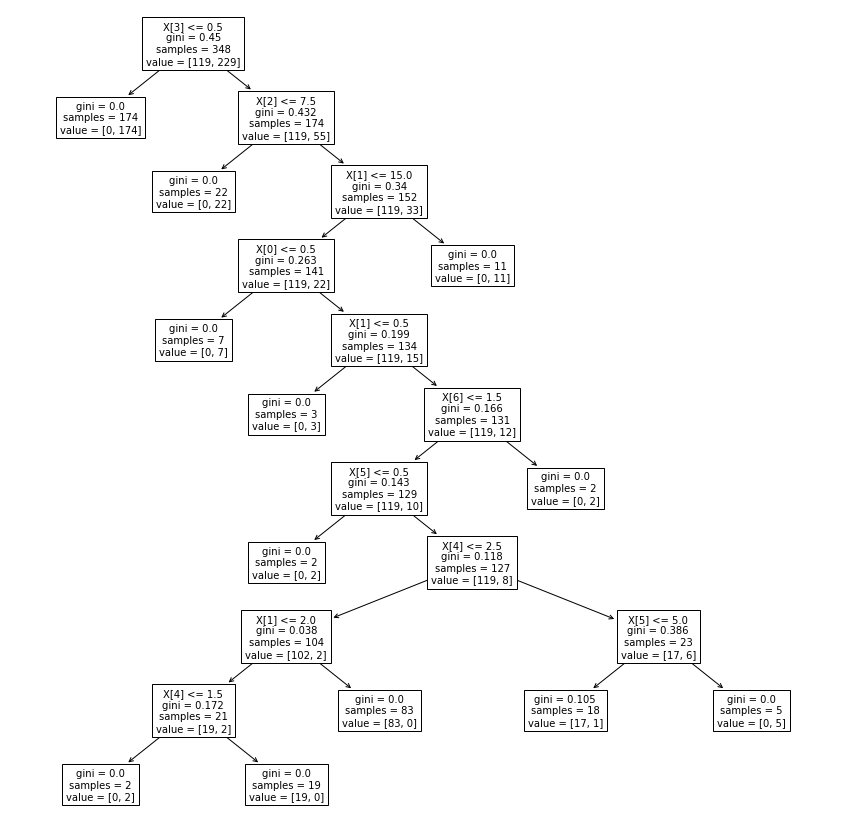

In [34]:
from sklearn.tree import DecisionTreeClassifier
dtr = DecisionTreeClassifier()
dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

# plot tree
plt.figure(figsize=(15,15))  # set plot size (denoted in inches)
plot_tree(dtr, fontsize=10)
#plt.show()

classification_quality(y_test, y_pred)
compilance_print('DecisionTreeClassifier', y_test, y_pred, 'cls')




from sklearn.tree import export_graphviz
# Creates dot file named tree.dot
export_graphviz(
            dtr,
            out_file =  "myTreeName.dot",
            feature_names = list(X_train.columns),
            class_names = ['Не Сдал', 'Сдал'],
            filled = True,
            rounded = True)
!dot -Tpng myTreeName.dot -o outfile1.png

### ExtraTreeClassifier Model

In [29]:
from sklearn.tree import ExtraTreeClassifier
extr = ExtraTreeClassifier()
extr.fit(X_train, y_train)

y_pred = extr.predict(X_test)

# plot tree
#plt.figure(figsize=(20,20))  # set plot size (denoted in inches)
#plot_tree(extr, fontsize=10)
#plt.show()

classification_quality(y_test, y_pred)
compilance_print('ExtraTreeClassifier', y_test, y_pred, 'cls')

Accuracy: 0.992
Recall: 0.9941176470588236
Precision: 0.9878048780487805
F1: 0.9908685806121703
Weighted Recall: (0.9878048780487805, 0.9941176470588236, 0.9908685806121703, None)


### MLPClassifier Model

In [30]:
from sklearn.neural_network import MLPClassifier
MLPCl = MLPClassifier()
MLPCl.fit(X_train, y_train)

y_pred = MLPCl.predict(X_test)

classification_quality(y_test, y_pred)
compilance_print('MLPClassifier', y_test, y_pred, 'cls')

Accuracy: 0.976
Recall: 0.9823529411764707
Precision: 0.9651162790697674
F1: 0.9729456749152298
Weighted Recall: (0.9651162790697674, 0.9823529411764707, 0.9729456749152298, None)


/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Example how to return real values from hash to encode decision tree

In [57]:
def get_dict(input):
    df = input.copy()
    total_zip = {}
    for col in pd.DataFrame(df.iloc[:,1:-1]).columns:
        list_answers = list(set(df[col]))
        encoder = LabelEncoder()
        filename = f"{build_path}/{str(col).replace('/', '-')}_class_linear_encoder.npy" 
        encoder.classes_ = np.load(filename, allow_pickle=True)
        list_encouder = encoder.transform(pd.DataFrame(list_answers))
        total_zip[col] = dict(zip(list_answers, list_encouder))
    return total_zip


def get_answer_by_index(_dict, question, index):
    return list(_dict.get(question).keys())[list(_dict.get(question).values()).index(index)]

In [58]:
get_answer_by_index(get_dict(debug_data), "14.Увлекаетесь ли Вы спортом?", 0)

/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'Другой ответ'

In [59]:
get_dict(debug_data).get("14.Увлекаетесь ли Вы спортом?").get("Другой ответ")

0

In [60]:
get_dict(debug_data).get("8.Как много Вы пропускаете аудиторных занятий?")

{'Не пропускаете': 0,
 'Среднее количество пропусков': 2,
 'Регулярно пропускаете': 1}

## Matrix
That table helps to understand which model is better for my work

In [40]:
pd.DataFrame(index=model_array, columns=metrics_list, data=output_array).T

,Perceptron,RandomForest,GradientBoosting,MultinomialNB,ComplementNB,GaussianNB,BernoulliNB,SVC,LinearSVC,DecisionTreeClassifier,ExtraTreeClassifier,MLPClassifier
Accuracy,0.824,1.0,1.0,0.832,0.864,0.92,0.872,0.952,0.848,1.0,0.992,0.976
Balanced Accuracy,0.811029,1.0,1.0,0.816912,0.9,0.941176,0.905882,0.964706,0.828676,1.0,0.994118,0.982353
Recall,0.811029,1.0,1.0,0.816912,0.9,0.941176,0.905882,0.964706,0.828676,1.0,0.994118,0.982353
Precision,0.796717,1.0,1.0,0.805587,0.850877,0.9,0.857143,0.934783,0.824477,1.0,0.987805,0.965116
F1,0.802783,1.0,1.0,0.81062,0.856816,0.913194,0.864719,0.946824,0.826503,1.0,0.990869,0.972946
MSE,None,None,None,None,None,None,None,None,None,None,None,None
RMSE,None,None,None,None,None,None,None,None,None,None,None,None
MAE,None,None,None,None,None,None,None,None,None,None,None,None
R2,None,None,None,None,None,None,None,None,None,None,None,None


# Model result

In [61]:
my_model = dtr  # My own prefix of DecisionTreeClassifier

I decided to use DecisionTree Classifier model due to its metrix

In [63]:
# save the model to disk
filename = f'{build_path}/DecisionTreeClassifier.sav'
pickle.dump(my_model, open(filename, 'wb'))

# Load an existed model from disk to use it in product

#my_model = pickle.load(open(filename, 'rb'))

/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/alexgiving/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


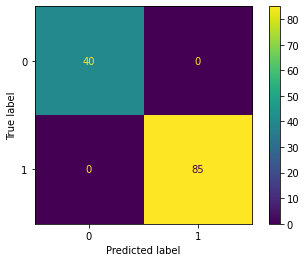

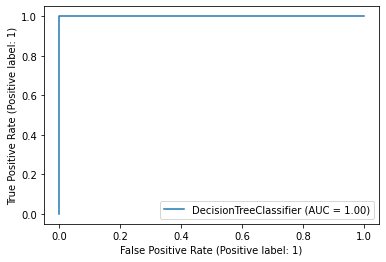

In [43]:
# Output confusion matrix and ROC/AUC curve
graph_show(my_model, X_test, y_test)

That metrics shows the accuracy of model. As we can see that models return very few False-Positive and True-Negative errors

# Validation

In [44]:
# Get predicted results of validation selection
# NOTE: Validation selection was not used for training model thus the results are objective
# Also X_val.iloc[:,1:] used for hiding from model hash of students names
y_pred_val = my_model.predict(X_val.iloc[:,1:])

These functions allow to output results of validation

In [45]:
def print_with_name():
    print(f'Студент {name_hash[X_val.iloc[i, 0]][1]} предположительно {"сдал(а)" if y_pred_val[i] == 1 else "не сдал(а)"}, в жизни {"сдал(а)" if y_val.iloc[i] == 1 else "не сдал(а)"}')

def print_with_id():
    print(f'Студент №{i+1} предположительно {"сдал(а)" if y_pred_val[i] == 1 else "не сдал(а)"}, в жизни {"сдал(а)" if y_val.iloc[i] == 1 else "не сдал(а)"}')

In [46]:
error_counter = 0
total = 0
for i in range(len(y_pred_val)):
    if y_pred_val[i] != y_val.iloc[i] == 1:
        error_counter += 1
    total += 1
    print_with_id()
print(f'There were {error_counter} from {total} error(s)!')

Студент №1 предположительно сдал(а), в жизни сдал(а)
Студент №2 предположительно сдал(а), в жизни сдал(а)
Студент №3 предположительно сдал(а), в жизни сдал(а)
Студент №4 предположительно сдал(а), в жизни сдал(а)
Студент №5 предположительно не сдал(а), в жизни не сдал(а)
Студент №6 предположительно сдал(а), в жизни сдал(а)
Студент №7 предположительно не сдал(а), в жизни не сдал(а)
Студент №8 предположительно сдал(а), в жизни сдал(а)
Студент №9 предположительно сдал(а), в жизни сдал(а)
Студент №10 предположительно сдал(а), в жизни сдал(а)
Студент №11 предположительно не сдал(а), в жизни не сдал(а)
Студент №12 предположительно не сдал(а), в жизни не сдал(а)
Студент №13 предположительно не сдал(а), в жизни не сдал(а)
Студент №14 предположительно не сдал(а), в жизни не сдал(а)
Студент №15 предположительно сдал(а), в жизни сдал(а)
Студент №16 предположительно не сдал(а), в жизни не сдал(а)
Студент №17 предположительно сдал(а), в жизни сдал(а)
Студент №18 предположительно сдал(а), в жизни сда

# Validation with my answers

In [47]:
my_questions = ["Учащийся", "16.Работаете ли Вы?", "14.Увлекаетесь ли Вы спортом?", 
                "9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?",
                "8.Как много Вы пропускаете аудиторных занятий?", "6.Бывают ли у Вас долги по экзаменам/зачетам?", 
                "2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?", "1.Участвуете ли Вы в олимпиадах?" ]


my_answers =    [
                "Алексей",                                  # Учащийся
                "Да",                                       # 16.Работаете ли Вы?
                "да, хожу на фитнес или в тренажерный зал", # 14.Увлекаетесь ли Вы спортом?
                "Готовлюсь только перед занятиями",         # 9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?
                "Не пропускаете",                           # 8.Как много Вы пропускаете аудиторных занятий?
                "Нет",                                      # 6.Бывают ли у Вас долги по экзаменам/зачетам?
                "нет",                                      # 2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?
                "Нет",                                      # 1.Участвуете ли Вы в олимпиадах?
                ]


df = pd.DataFrame(data=[my_answers], columns=my_questions)

for col in pd.DataFrame(df.iloc[:,1:]).columns:             # Iterate by df without name
    encoder = LabelEncoder()
    filename = f"{build_path}/{str(col).replace('/', '-')}_class_linear_encoder.npy" 
    encoder.classes_ = np.load(filename, allow_pickle=True) # Import encouder fit data
    df[col] = encoder.transform(df[col])


y_pred_my = my_model.predict(df.iloc[:,1:])                 # Without name
print(f'{df.iloc[0,0]} предположительно {"сдал(а)" if y_pred_my == 1 else "не сдал экзамен"}')

Алексей предположительно сдал(а)


# Correlation matrix

In [48]:
def exists(path):
    try:
        os.stat(path)
    except OSError:
        return False
    return True

In [49]:
# Replace all text output to index
# Used for outputing correlation matrix
label_encoder = LabelEncoder()
label_data = data.iloc[:,1:].copy()

for col in label_data.columns:
    filename = f"{build_path}/{col.replace('/', '-')}_class_linear_encoder.npy"
    if exists(filename):
        label_encoder.classes_ = np.load(filename, allow_pickle=True)
    else: 
        label_encoder.fit(data[col])
#   always:
    label_data[col] = label_encoder.transform(label_data[col])


# Creating correlation matrix
rs = np.random.RandomState(0)
corr = label_data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

,16.Работаете ли Вы?,14.Увлекаетесь ли Вы спортом?,9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,8.Как много Вы пропускаете аудиторных занятий?,6.Бывают ли у Вас долги по экзаменам/зачетам?,"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",1.Участвуете ли Вы в олимпиадах?,Сдал
16.Работаете ли Вы?,1.000000,0.089090,0.076887,-0.039203,-0.037762,-0.065567,-0.041863,-0.200526
14.Увлекаетесь ли Вы спортом?,0.089090,1.000000,-0.101621,-0.177372,0.047282,-0.109349,-0.005452,0.186185
9.Сколько времени Вы уделяете самостоятельной подготовке к занятиям (в среднем)?,0.076887,-0.101621,1.000000,0.361126,-0.158651,-0.010636,-0.047685,-0.442289
8.Как много Вы пропускаете аудиторных занятий?,-0.039203,-0.177372,0.361126,1.000000,-0.387457,-0.050922,-0.084693,-0.640253
6.Бывают ли у Вас долги по экзаменам/зачетам?,-0.037762,0.047282,-0.158651,-0.387457,1.000000,0.031436,0.180910,0.343496
"2.Посещаете ли Вы дополнительные занятия (неважно, в вышке или вне)?",-0.065567,-0.109349,-0.010636,-0.050922,0.031436,1.000000,0.178260,0.021498
1.Участвуете ли Вы в олимпиадах?,-0.041863,-0.005452,-0.047685,-0.084693,0.180910,0.178260,1.000000,0.137030
Сдал,-0.200526,0.186185,-0.442289,-0.640253,0.343496,0.021498,0.137030,1.000000
